# Data Matching with Active Machine Learning

This problem involves linking two datasets containing information on restuarants, one containing data on wage violations and the other on health inspection results. The only way to link these datasets is by comparing resturarant names and addresses.

The below techniques are leveraged in my solution, which are described in more detail throughout the notebook.

1. Finding broadly similar records (refered to as blocking) using an approximate similarity join technique
2. Parsing address components using a linear chain conditional random field model
3. Estimating record similarity using a broad array of string similarity algorithms
4. Training a machine learning model using active learning to predict matches

In [58]:
import pickle
import re
import os
from random import random
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
from IPython.display import Image

import dask
from dask import delayed
import dask.dataframe as dd

from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
from bokeh.layouts import gridplot

from visualizer.bokeh_charts import *

output_notebook()

#%matplotlib inline
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth',500)

path = os.getcwd()

Loading BokehJS ...

In [4]:
# Adjust notebook stcreen width
display(HTML("<style>.container { width:75% !important; }</style>"))

### Setting up a local Dask cluster to speed some calculations  
Dask allows for parallel computations on DataFrames. In this case, I'm leveraging the four cores of my machine

In [5]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)
client.cluster

## Profile the data  

I previously profiled the raw wage and restuarant data. I searched for all overlapping attributes that could be compared. The overlapping restuarant attributes in these datasets are restuarant name, address, city, and zip code.  

I also found a way to identify distinct restuarant locations in both datasets. Each restuarant location is identified using two "id" columns, one related the restuarant ("id") and one related to an instance of that restuarant in the data ("row_id"). Each restuarant location can have more than one entry in the datasets. In the case of the wage data, two names are available for each restuarant, with one appearing to represent a legal name that can sometimes differ from the marketed name. I am testing both names.

The "id_concat" field is distinct and is used to identify a specific instance of a restuarant location. Ultimately, I would like to find the best match for each restuarant ("id" level).

I removed restuarant observations that have duplicated attribute values and parked the results in multiple [parquet files](https://parquet.apache.org/). These can be read into Dask DataFrames for parallel computation.

#### Read parquet files into distributed Dask DataFrames

In [24]:
data_path = path + '/data/'

wage_path = data_path + 'wage'
inspection_path = data_path + 'inspection'

wage = dd.read_parquet(wage_path) 
inspection = dd.read_parquet(inspection_path)

#### View sample records  
The name_address field is a concatenation of all the restuarant attributes. I am using this field in the "blocking" phase described below.

In [6]:
wage.head()

,id,row_id,name,address,city,zip,name_address
id_concat,,,,,,,
1001372_114565t,1001372,114565t,BLAIR TEMPORARIES & STAFFING,8701 GEORGIA AVE STE 700,SILVER SPRINGS,20910,BLAIR TEMPORARIES & STAFFING 8701 GEORGIA AVE STE 700 20910 SILVER SPRINGS
1002623_166048l,1002623,166048l,MISTICK PBT,1300 BRIGHTON ROAD,PITTSBURGH,15212,MISTICK PBT 1300 BRIGHTON ROAD 15212 PITTSBURGH
1002623_166048t,1002623,166048t,TOM MISTICK AND SONS,1300 BRIGHTON ROAD,PITTSBURGH,15212,TOM MISTICK AND SONS 1300 BRIGHTON ROAD 15212 PITTSBURGH
1002991_158872l,1002991,158872l,AJP MNANGEMEN INC TTK CORPORATION,30035 ALICIA PKWY,LAGUNA HILLS,92677,AJP MNANGEMEN INC TTK CORPORATION 30035 ALICIA PKWY 92677 LAGUNA HILLS
1002991_158872t,1002991,158872t,FANTASIC SAM,30035 ALICIA PKWY,LAGUNA HILLS,92677,FANTASIC SAM 30035 ALICIA PKWY 92677 LAGUNA HILLS


In [7]:
inspection.head()

,id,row_id,name,address,city,zip,name_address
id_concat,,,,,,,
2128478_96307,2128478,96307,SANDWICH INN,110 NE 16 AVE,GAINESVILLE,32601,SANDWICH INN 110 NE 16 AVE 32601 GAINESVILLE
2128482_96312,2128482,96312,SONNYS REAL PIT BBQ OF GAINESVILLE,2700 NE WALDO RD,GAINESVILLE,32609,SONNYS REAL PIT BBQ OF GAINESVILLE 2700 NE WALDO RD 32609 GAINESVILLE
2128496_96316,2128496,96316,GAINESVILLE GOLF & COUNTRY CLB,7300 SW 35 WAY,GAINESVILLE,32608,GAINESVILLE GOLF & COUNTRY CLB 7300 SW 35 WAY 32608 GAINESVILLE
2128502_96318,2128502,96318,MCDONALDS OF GAINESVIL,201 NW 13 ST,GAINESVILLE,32601,MCDONALDS OF GAINESVIL 201 NW 13 ST 32601 GAINESVILLE
2128513_96319,2128513,96319,ARBYS 95,1405 SW 13 ST,GAINESVILLE,32608,ARBYS 95 1405 SW 13 ST 32608 GAINESVILLE


#### Records counts, number of partitions  

In [21]:
print("""
Record counts:  wage:       {:,}   distinct restuarants: {:,} - partitions: {}
                inspection:  {:,}   distinct restuarants:  {:,} - partitions: {}""".format(wage.compute().shape[0], 
                                                                                        len(wage.id.compute().unique()),
                                                                                        wage.npartitions,
                                                                                        inspection.compute().shape[0],
                                                                                        len(inspection.id.compute().unique()),
                                                                                        inspection.npartitions))


Record counts:  wage:       363,755   distinct restuarants: 208,806 - partitions: 4
                inspection:  53,804   distinct restuarants:  53,804 - partitions: 4


## Grouping similar records (Blocking)  
Blocking is the process of grouping similar records for more rigorous comparisons. It is a necessary step in any data matching workflow and allows the process to scale. Without blocking, we would have to compare every record in the wage dataset to every record in the inspection dataset, which would require 20 billion comparisons. Almost all of these would be meaningless because the records would bare no resemblence to each other.

There are a number of commonly used blocking methods. The simplest involves comparing records that share some common elements, such as zip code, or perhaps some combination of elements, such as address number and zip code or name and city. [Phonetic encodings](https://en.wikipedia.org/wiki/Phonetic_algorithm) can also be used here. Then, any records that share one of these "blocking key" values will be compared. This method becomes harder to leverage if data elements are unreliable, missing, or if matching attributes can vary widely in spelling or formatting.

There are other blocking methods that are more robust to these data problems. Approximate similarity joins are one family of methods. These methods seek to join records that are above some specified similarity threshold. MinHash with Locality Sensitive Hashing is one implementation of this approach and is described in the book [Mining of Massive DataSets](http://www.mmds.org/). This method employs a hashing technique to approximate the [Jaccard Similarity](https://en.wikipedia.org/wiki/Jaccard_index) between two strings. A similarity threshold is provided and only records with an appoximate Jaccard Similarity score above the threshold are returned. The algorithm is design to find these similar records without the need to review every possible record pair combination.

#### Jaccard distance
Jaccard similairty = set intersection / set union

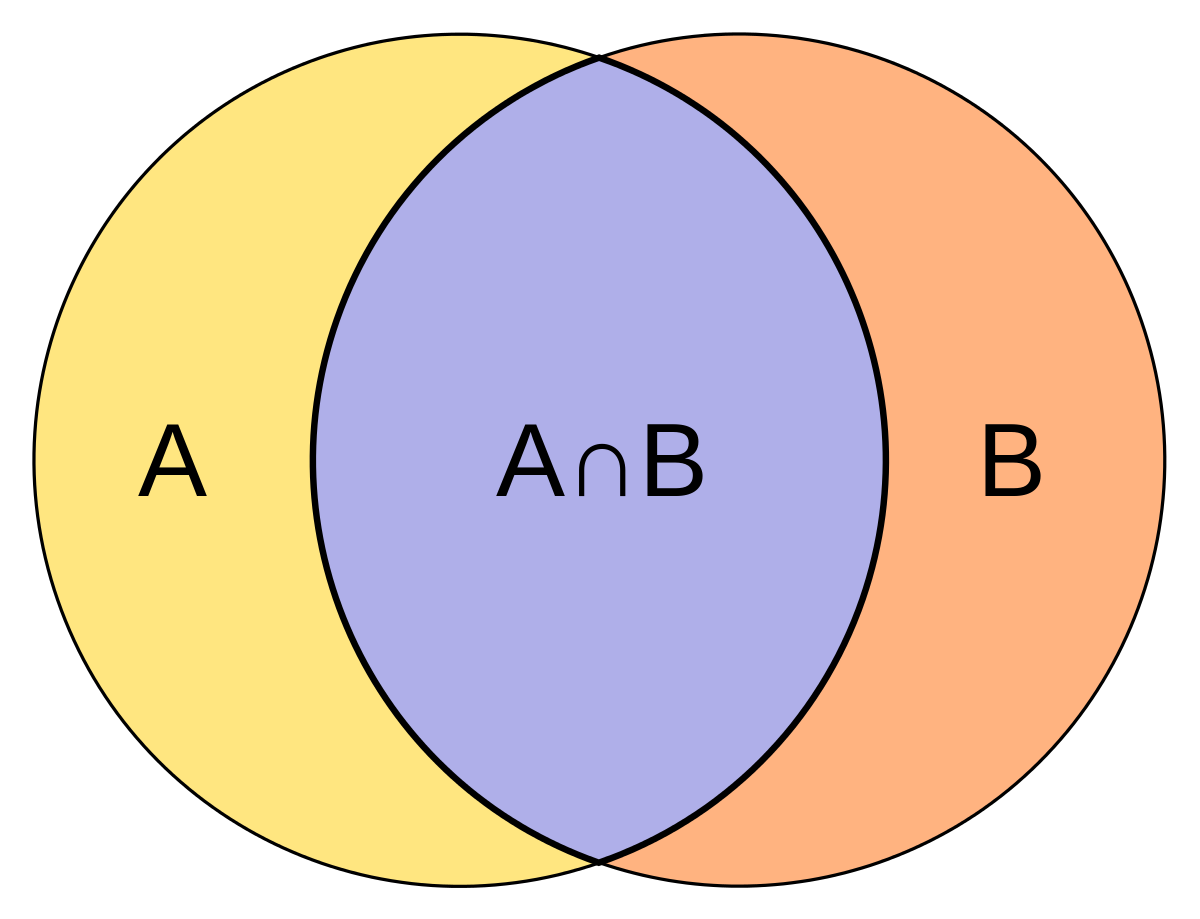

In [35]:
Image(filename = path + '/docs/jaccard.png', width=300)

#### Jaccard distance example calculation using n-grams  
String are converted to sets of n-grams before calculating Jaccard similarity. The longer the n-gram, the more of the underlying string's structure is preserved

In [51]:
# Convert string to ngrams
def ngrams(token, n):
    token = str(token).strip()
    token_len = len(token) + 1
    return set([token[i:i+n] for i in range(token_len-n)])

# Generating tri-grams here
n = 3
x = ngrams("SOME BUSINESS NAME INC", n)
y = ngrams("ANOTHER BUSINESS NAME", n)

print("{0}\n\n{1}".format(x, y))

{'NES', 'ESS', 'OME', 'INC', 'E I', 'E B', 'SOM', 'USI', 'INE', ' NA', ' BU', 'S N', 'NAM', 'SIN', ' IN', 'SS ', 'AME', 'ME ', 'BUS'}

{'NES', 'ESS', 'ANO', 'OTH', 'THE', 'R B', 'USI', 'INE', ' NA', 'NOT', 'ER ', ' BU', 'S N', 'SIN', 'NAM', 'SS ', 'AME', 'BUS', 'HER'}


In [52]:
# Calculated Jaccard distance on the n-grams
set_intersection = len(x.intersection(y))
set_union = len(x.union(y))
jaccard = set_intersection / set_union

print("""
Number of common ngrams: {0}
Total distinct n-grams: {1}
Jaccard similarity: {2:.1f}""".format(set_intersection, 
                                      set_union,  
                                      jaccard * 100))


Number of common ngrams: 12
Total distinct n-grams: 26
Jaccard similarity: 46.2


#### Generate block groups  using an approximate jaccard similarity join  
I implemented the MinHashLSH class using Dask DataFrames for multi-core distributed processing.  

There are a number of parameters. These govern how precise the estimated Jaccard similarity will be at the expense of data process time and size. These parameters are also used to adjust the probability that a record pair at the specified threshold will be returned.  

For this particular problem, I have found that record pairs with a Jaccard similarity below 0.5 to be highly dissimilar. I have also chosen the parameters "rows" and "rows_per_band" to give a good balance between returning too many false positives (pairs that are below my threshold) while having a high probability that pairs at or above my threshold will be returned. This can be quantified.

In [13]:
from blocker.blocker import MinHashLSH

In [41]:
jaccard_distances = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

rows_per_bin = 100 / 4

# The probability of a record pair with a given Jaccard similarity will be returned
# given a set of rows and rows_per_band parameter values
prob_of_return = [MinHashLSH.get_band_proba(jd, 100, rows_per_bin)[0] for jd in jaccard_distances]

distances_and_probs = zip(jaccard_distances, prob_of_return)

for distance, prob in distances_and_probs:
    print("Jaccard distance: {0}\tProbability of returned: {1:.2f}".format(distance, prob))

Jaccard distance: 0.1	Probability of returned: 0.00
Jaccard distance: 0.2	Probability of returned: 0.04
Jaccard distance: 0.3	Probability of returned: 0.18
Jaccard distance: 0.4	Probability of returned: 0.48
Jaccard distance: 0.5	Probability of returned: 0.80
Jaccard distance: 0.6	Probability of returned: 0.97
Jaccard distance: 0.7	Probability of returned: 1.00
Jaccard distance: 0.8	Probability of returned: 1.00
Jaccard distance: 0.9	Probability of returned: 1.00


In [21]:
blocker = MinHashLSH(df_a = wage, 
                     df_b = inspection, 
                     id_col = 'id_concat', 
                     hash_col = 'name_address', 
                     n_shingles = 3, 
                     rows = 100, 
                     rows_per_band = 4, 
                     threshold = 0.5,
                     hash_func = hash)

#### Dask creates a directed asyclical graph (DAG) of steps to process in parallel

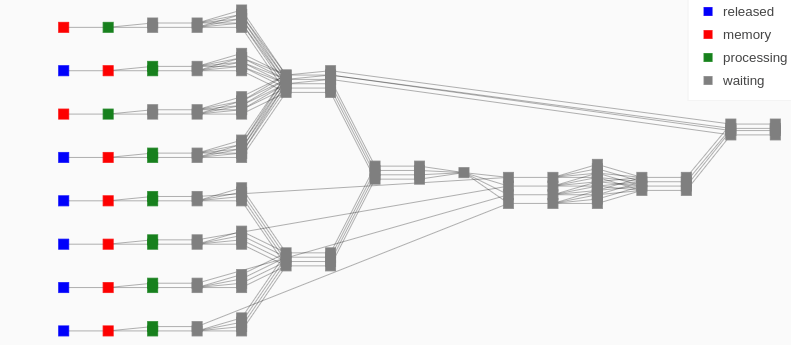

In [33]:
Image(filename = path + '/docs/dask_dag.png', width=700)

In [38]:
# Initiate the blocking proces
block_groups = blocker.join_bands()

In [34]:
# Storing blocking group results
#block_groups.to_pickle(path + '/data/block_groups.p')
block_groups = pd.read_pickle('data/block_groups.p')

#### Review block group results

In [13]:
print("The blocking processes resulted in {0:,} candidate record pairs".format(block_groups.shape[0]))

The blocking processes resulted in 10,153 candidate record pairs


In [14]:
# Sample block group pairs
cols = ['name_a', 'name_b', 'address_a', 'address_b', 'zip_a', 'zip_b', 'city_a', 'city_b','sim']

block_groups[cols].sample(10).head(10)

,name_a,name_b,address_a,address_b,zip_a,zip_b,city_a,city_b,sim
1692,US AIRWAYS,LANDSHARK,320 TERMINAL DRIVE,50 TERMINAL DR,33315,33315,FORT LAUDERDALE,FORT LAUDERDALE,0.500000
6670,NABBQ INC,DELRAY DAIRY QUEEN,710 LINTON BLVD,1000 LINTON BLVD,33444,33444,DELRAY BEACH,DELRAY BEACH,0.508475
104,CLARION SUITES MAINGATE,DUNKIN DONUTS,7888 W IRLO BRONSON MEMORIAL HWY,8898 W IRLO BRONSON MEMORIAL HWY,34747,34747,KISSIMMEE,KISSIMMEE,0.500000
7620,I DRIVE CATTLE COMPANY INC,URBAN TIDE,8801 INTERNATIONAL DRIVE,9801 INTERNATIONAL DRIVE,32819,32819,ORLANDO,ORLANDO,0.514706
6487,MAINGATE RESORT & SPA,TASTE OF CHINA,7300 W IRLO BRONSON MEMORIAL HWY,7832 W IRLO BRONSON MEMORIAL HWY,34747,34747,KISSIMMEE,KISSIMMEE,0.517647
2316,BROOKES RESTAURANT & LOUNGE,NESTORS RESTAURANT,4450 HANCOCK BRIDGE,4400 HANCOCK BRIDGE PKWY,33903,33903,NORTH FORT MYERS,NORTH FORT MYERS,0.580247
95,FIRST BELL INC,THE OLIVE GARDEN,1700 W INTERNATIONAL SPEEDWAY BLVD,1780 W INTERNATIONAL SPEEDWAY BLVD,32114,32114,DAYTONA BEACH,DAYTONA BEACH,0.590361
8031,GOLDEN KRUST CARIBBEAN BAKERY & GRILL,GOLDEN KRUST BAKERY,2525 E HILLSBOROUGH AVE,2525 E HILLSBOROUGH AVE,33610,33610,TAMPA,TAMPA,0.708333
7862,UNIVERSAL ORLANDO,VIP LOUNGE,1000 UNIVERSAL STUDIOS PLAZA BLVD,1000 UNIVERSAL STUDIOS PL,32819,32819,ORLANDO,ORLANDO,0.590164
4595,MAI KAI INC,JALISCO INC,3599 N FEDERAL HWY,700 N FEDERAL HWY,33308,33304,FORT LAUDERDALE,FORT LAUDERDALE,0.523810


#### Check the distribution of the block group record pair similarity scores  
The MinHashLSH class filters out pairs with similarity below the specified threshold. This chart shows that it is less common for records pairs to be similar. This is in line with my expections because matching pairs are rare.

In [15]:
plot_size_and_tools = {'plot_height': 300, 
                       'plot_width': 500,
                       'y_range': (0, 50),
                       'toolbar_location': None,
                       'tools': 'hover',
                       'x_axis_label': 'similarity bin',
                       'y_axis_label': None}


block_groups_chart = BinnedValuesChart(df = block_groups,
                                       id_col = 'id_concat_a',
                                       bin_col = 'sim',
                                       n_bins = 10,
                                       title = "Distribution of Jaccard similarity scores (100 = 10)",
                                       plot_size_and_tools = plot_size_and_tools)

show(block_groups_chart.generate_binned_chart())

## Feature engineering

### Extracting address components using Conditional Random Fields  

Addresses are messy and it can be helpful to specifically compare certain components, such as numbers and street names. I'm leveraging a linear chain CRF model here to parse out address components. The parser was inspired by DataMade's usaddress package, https://github.com/datamade/usaddress, https://parserator.datamade.us/usaddress. My implementation was trained on addresses from the wages and inspection datasets.

The parser will categorize multiple address components but I am interested specifically in the address number and street name.

In [42]:
from address_parser.parser import Parser

#### Examples

In [4]:
Parser.tag_address("123 N. Main St. Apt 1")

{'AddressNumber': '123',
 'StreetNamePreDirectional': 'N.',
 'StreetName': 'Main',
 'StreetNamePostType': 'St.',
 'OccupancyType': 'Apt',
 'OccupancyIdentifier': '1'}

In [6]:
Parser.tag_address("PO Box 100")

{'USPSBoxType': 'PO Box', 'USPSBoxID': '100'}

#### Address parser model performance
Classification performance for each address component in the model. The performance is weak on OccupancyType and would benefit from more training data. Since I am not leveraging this component for my analysis, I am leaving it as is for now.

| address component         | precision | recall |    f1 | support |
|---------------------------|----------:|-------:|------:|--------:|
| AddressNumber             |     1.000 |  1.000 | 1.000 |      27 |
| StreetNamePreType         |     1.000 |  1.000 | 1.000 |      10 |
| StreetName                |     1.000 |  1.000 | 1.000 |      30 |
| StreetNamePostType        |     1.000 |  0.941 | 0.970 |      17 |
| StreetNamePreDirectional  |     1.000 |  1.000 | 1.000 |       7 |
| OccupancyType             |     0.800 |  0.571 | 0.667 |       7 |
| OccupancyIdentifier       |     0.833 |  1.000 | 0.909 |      10 |
| USPSBoxType               |     1.000 |  1.000 | 1.000 |       1 |
| USPSBoxID                 |     1.000 |  1.000 | 1.000 |       1 |
| StreetNamePostDirectional |     0.000 |  0.000 | 0.000 |       0 |
| SubaddressType            |     1.000 |  1.000 | 1.000 |       1 |
| SubaddressIdentifier      |     1.000 |  1.000 | 1.000 |       1 |
|                           |           |        |       |         |
| avg / total               |     0.973 |  0.964 | 0.966 |     112 |

### Extract common company name tokens  
There are alot of common tokens in business names that can confuse a classifier. For instance, "restuarant",  "inc", "company", etc. These common tokens sometimes result in high similarity scores for non-matching business names. There is a technique called [Soft TF/IDF](https://www.enigma.com/blog/improving-entity-resolution-with-the-soft-tf-idf-algorithm) that tries to address this. For now, I am going to capture a group of common tokens and create versions of the business names in which they are removed. I can then calculate similarity scores for both versions of the names.

In [16]:
all_names = pd.concat([wage.compute().name, inspection.compute().name], ignore_index =True)
all_names = all_names.apply(lambda x: x.split(' '))

name_counts = {}

for index, name in all_names.iteritems():
    for token in name:
         if token in name_counts.keys():
            name_counts[token] += 1
         else:
            name_counts[token] = 1
            
name_counts_tuple = [(key, value) for key, value in name_counts.items()]
name_counts_tuple.sort(key=lambda x: x[1], reverse=True)

In [17]:
top_300_tokens = [name for (name, count) in name_counts_tuple[:300]]

name_counts_tuple[:10]

[('INC', 110031),
 ('LLC', 38734),
 ('&', 32235),
 ('OF', 17421),
 ('SERVICES', 14028),
 ('RESTAURANT', 12185),
 ('AND', 11653),
 ('CENTER', 10406),
 ('THE', 10116),
 ('COMPANY', 8665)]

### Generate feature matrix  
All of the feature engineering required to go from a DataFrame of block group pairs to the feature matrix for a model is included in this sci-kit learn Pipeline. The Pipeline is composed of multiple custom transformers that I created for data matching problems. The entire transformation is set in motion with one line of code...

features = pipeline.fit_transform(block_groups)  

During this process, multiple, different string similarity metrics, including some varations of the metrics, are applied to the input name and address data.

Some notable metrics include...   
[Jaro Winkler](https://en.wikipedia.org/wiki/Jaro%E2%80%93Winkler_distance)  
[Damerau–Levenshtein](https://en.wikipedia.org/wiki/Damerau%E2%80%93Levenshtein_distance)  
[Token-set Ratio](https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/)  

In [18]:
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from transformers.general import DataFrameSelector
from transformers.scoring import StringSimilarity
from transformers.parsing import AddressParser
from transformers.cleaning import TokenRemover
from transformers.utilities import dataframe_from_pipeline, get_feature_names

In [19]:
name_and_address = ['levenshtein', 'jaro_winkler', 'jaro_winkler_tk', 'token_set']
address_number = ['levenshtein', 'jaro_winkler','num_perc_diff']
address_street = ['levenshtein', 'jaro_winkler']
zip5 = ['levenshtein']
city = ['levenshtein']


no_transformations = make_pipeline(DataFrameSelector(['id_concat_a', 'id_concat_b']))


parse_address = make_pipeline(AddressParser(addr_a = 'address_a',
                                            addr_b = 'address_b'))


remove_name_tokens  = make_pipeline(TokenRemover(col_to_clean = 'name',
                                                 tokens_to_remove = top_300_tokens))


name_similarity = make_pipeline(DataFrameSelector(['name_a', 'name_b']),
                                StringSimilarity(name_and_address))


name_uncommon_similarity = make_pipeline(DataFrameSelector(['nameuncommon_a', 'nameuncommon_b']),
                                         StringSimilarity(name_and_address))


address_similarity = make_pipeline(DataFrameSelector(['address_a', 'address_b']),
                                   StringSimilarity(name_and_address))


address_number_similarity = make_pipeline(DataFrameSelector(['addrnumber_a', 'addrnumber_b']),
                                          StringSimilarity(address_number))

                                          
address_street_similarity = make_pipeline(DataFrameSelector(['addrstreetname_a', 'addrstreetname_b']),
                                          StringSimilarity(address_street))


zip_similarity = make_pipeline(DataFrameSelector(['zip_a', 'zip_b']),
                               StringSimilarity(zip5))


city_similarity = make_pipeline(DataFrameSelector(['city_a', 'city_b']),
                                StringSimilarity(city))


stages = [('no_transformations', no_transformations),
          ('name_similarity', name_similarity),
          ('name_uncommon_similarity', name_uncommon_similarity),
          ('address_similarity', address_similarity),
          ('address_number_similarity', address_number_similarity),
          ('address_street_similarity', address_street_similarity),
          ('zip_similarity', zip_similarity),
          ('city_similarity', city_similarity)]

                                          
calculate_features = FeatureUnion(transformer_list = stages)

pipeline = Pipeline([('parse_address', parse_address),
                     ('remove_name_tokens', remove_name_tokens),
                     ('calculate_features', calculate_features)])         
                                          
features = pipeline.fit_transform(block_groups)

In [20]:
# Converting feature matrix back to Pandas DataFrame
feature_names = get_feature_names(stages)

types = {name: float for name in feature_names if name not in ['id_concat_a', 'id_concat_b']}

features_df = dataframe_from_pipeline(features, stages, types)

features_df.to_pickle('data/features.p')

In [25]:
features_df = pd.read_pickle('data/features.p')

In [59]:
features_df.head()

,id_concat_a,id_concat_b,name_levenshtein,name_jaro_winkler,name_jaro_winkler_tk,name_token_set,nameuncommon_levenshtein,nameuncommon_jaro_winkler,nameuncommon_jaro_winkler_tk,nameuncommon_token_set,address_levenshtein,address_jaro_winkler,address_jaro_winkler_tk,address_token_set,addrnumber_levenshtein,addrnumber_jaro_winkler,addrnumber_num_perc_diff,addrstreetname_levenshtein,addrstreetname_jaro_winkler,zip_levenshtein,city_levenshtein
0,1476948_181502t,4053126_88677,68.0,93.0,100.0,100.0,NaN,0.0,NaN,0.0,26.0,76.0,80.0,62.0,100.0,100.0,0.0,0.0,0.0,100.0,81.0
1,1555526_20253t,6020514_99884,0.0,31.0,48.0,44.0,0.0,31.0,48.0,44.0,81.0,88.0,86.0,81.0,40.0,60.0,0.0,100.0,100.0,100.0,100.0
2,1369052_119298t,3565522_127328,38.0,61.0,77.0,51.0,25.0,55.0,55.0,31.0,81.0,92.0,89.0,88.0,25.0,67.0,163.0,100.0,100.0,100.0,100.0
3,1370799_135728t,2176597_101203,100.0,99.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,100.0,100.0,100.0,100.0
4,1637238_62121t,3788931_103540,91.0,98.0,90.0,95.0,91.0,98.0,90.0,95.0,87.0,96.0,86.0,93.0,100.0,100.0,0.0,100.0,100.0,100.0,100.0


## Develop a classifier using active machine learning  
[Active learning](https://en.wikipedia.org/wiki/Active_learning_(machine_learning)) is the process of leveraging machine learning to generate training data and estimate a model through an iteractive process. A complication of data matching is that training data is typically not available. Additionaly, special attention must be paid to ensure that training data is representative of all valid matching patterns. Depending on the matching task and the number of available attributes, matching records could have multiple valid combinations of similar attributes. Additionally, this can change from problem to problem.

I'm pulling a small sample of matching and non-matching records from the block group pairs generated above to seed the active learning process. This sample is used to fit a machine learning model. The model then makes predictions on all block group pair features. Three different types of samples are then returned for the user to label: pairs believed to be matches, pairs believed to be non-matches, and pairs that are closest to the decision boundary (0.5 match probability). The goal of this exercise is to generate training data that is skewed toward trickier pairs. These types of pairs occur infrequently and could be totally missed if record pairs were chosen randomly. Randomly choosing pairs would also be problematic because they are highly skewed toward one class, non-matches. 

After labeling, the new pairs are added to the training data and the process repeates. The model's precision and recall are calculated after each interval using k-fold cross validation, and the process continues until these scores stabilize and the user terminates the process. The final model is then estimated using k-fold cross validation and grid search to maximize the F1 score.

In [27]:
import random
from sklearn.ensemble import RandomForestClassifier
from learner.active_learner import ActiveLearner
from learner.utilities import get_labeled_samples

#### Find sample matches and non-matches  
Randomly sample blocking data for seed match and non-match pairs

In [24]:
seed = random.randint(1, 100)
block_groups.sample(10, random_state=seed)[['name_a', 'name_b', 'address_a', 'address_b', 
                                            'zip_a', 'zip_b', 'city_a', 'city_b']].head(10)

,name_a,name_b,address_a,address_b,zip_a,zip_b,city_a,city_b
7252,IHOP,RUN AWAY HOTDOGS,4736 US HWY 19,6829 US HWY 19,34652,34652,NEW PORT RICHEY,NEW PORT RICHEY
9013,FREEDOM VILLAGE OF SUN CITY CENTER,FREEDOM PLAZA DINING,912 AMERICAN EAGLE BLVD,1010 AMERICAN EAGLE BLVD,33573,33573,SUN CITY CENTER,SUN CITY CENTER
9344,VIC & ANGELOS,ROCCOS TACOS,290 E ATLANTIC AVE,110 E ATLANTIC AVE,33444,33444,DELRAY BEACH,DELRAY BEACH
3116,SUBWAY TALLAHASSEE MALL,DENNYS,2415 N MONROE ST,2690 N MONROE ST,32303,32303,TALLAHASSEE,TALLAHASSEE
7854,PINCH A PENNY,DOMINOS PIZZA,1857 LAKEWOOD RANCH BLVD,2551 LAKEWOOD RANCH BLVD,34211,34211,BRADENTON,BRADENTON
5936,VIZCAYA OF TAMPA INC,VIZCAYA,10905 N DALE MABRY HIGHWAY,10905 N DALE MABRY HWY,33618,33618,TAMPA,TAMPA
4859,TACO BELL,RED LOBSTER 0435,4951 W IRLO BRONSON MEMORIAL HWY,5690 W IRLO BRONSON MEMORIAL HWY,34746,34746,KISSIMMEE,KISSIMMEE
6213,DESTIN INN SUITES,INN ON DESTIN HARBOR,713 HARBOR BLVD,402 HARBOR BLVD,32541,32541,DESTIN,DESTIN
6005,TACO BUS INC,TACO BUS,913 EAST HILLSBOROUGH AVE,913 E HILLSBOROUGH AVENUE,33604,33604,TAMPA,TAMPA
9140,THE PLACE,THE CARLYLE,720 OCEAN DRIVE,1250 OCEAN DRIVE,33139,33139,MIAMI BEACH,MIAMI BEACH


In [35]:
# Choosing sample matches and sample non-matches by index location

matches_index = [6005, 5936, 4226, 3124, 9525]
nonmatches_index = [9140, 9344, 9013, 3825, 8724]

# Grabbing the features associated with these indexes
labeled_samples = get_labeled_samples(features_df, matches_index, nonmatches_index)

feature_cols = [column for column in labeled_samples.columns if column not in ['label', 'id_concat_a', 'id_concat_b']]

labeled_features = labeled_samples[feature_cols].fillna(value=-100.0, axis=1)
labeled_labels = labeled_samples['label']

In [36]:
# Sample matches
cols = ['name_a', 'name_b', 'address_a', 'address_b', 'zip_a', 'zip_b']

block_groups.loc[matches_index][cols].head()

,name_a,name_b,address_a,address_b,zip_a,zip_b
6005,TACO BUS INC,TACO BUS,913 EAST HILLSBOROUGH AVE,913 E HILLSBOROUGH AVENUE,33604,33604
5936,VIZCAYA OF TAMPA INC,VIZCAYA,10905 N DALE MABRY HIGHWAY,10905 N DALE MABRY HWY,33618,33618
4226,ICHIBAN JAPANESE STEAK HOUSE,ICIBAN JAPANESE STEAKHOUSE AND SUSHI VAR,675 3RD ST NORTH,675 N 3 ST,32250,32250
3124,MY PLACE BAR & GRILL,MY PLACE BAR AND GRILL,9550 BAYMEADOWS ROAD,9550 BAYMEADOWS RD 29,32256,32256
9525,DENNYS,DENNYS 7946,1700 E FOWLER AVE,1700 E FOWLER AVE,33612,33612


In [37]:
# Sample non-matches
block_groups.loc[nonmatches_index][cols].head()

,name_a,name_b,address_a,address_b,zip_a,zip_b
9140,THE PLACE,THE CARLYLE,720 OCEAN DRIVE,1250 OCEAN DRIVE,33139,33139
9344,VIC & ANGELOS,ROCCOS TACOS,290 E ATLANTIC AVE,110 E ATLANTIC AVE,33444,33444
9013,FREEDOM VILLAGE OF SUN CITY CENTER,FREEDOM PLAZA DINING,912 AMERICAN EAGLE BLVD,1010 AMERICAN EAGLE BLVD,33573,33573
3825,CATALINA HOTEL LLC,NASSAU SUITE HOTEL,1732 COLLINS AVENUE,1414 COLLINS AVENUE,33139,33139
8724,J2KC EQUITIES LLC,CHI PHI A TASTE OF TWO CITIES,11448 UNIVERSITY BLVD,11448 UNIVERSITY BLVD,32817,32817


#### Initiate active learner  
The active learner executes the following stages.
1. Fits a model to the labled pairs
2. Returns record pairs to label
3. Asks the user to label each record as a match (1) or not a match (0)
4. Adds the new labled pairs to the training data
5. Repeates step 1  

Once the model performance (precision and recall) has stabilized, the user can terminate the labeling process and fit the final model. I am doing only a few iterations here to avoid filling too much space in the notebook.  

This is my own, bare-bones implementation of an active learning process based on uncertaintly sampling. There are a number of more robust, flexible Python implementations that I would like to explore in the future; I've listed them in the Appendix at the bottom of the notebook.

In [43]:
learner = ActiveLearner(labeled_features = labeled_features,
                        labeled_labels = labeled_labels,
                        all_raw_data = block_groups,
                        all_features = features_df.fillna(value=-100.0, axis=1)[feature_cols],
                        sample_size=[3,3,3], # number least certain, match, not a match
                        cv = 5,
                        param_grid = {'n_estimators': [50, 100, 200], 
                                      'max_features': ['sqrt', 6, 8],
                                      'min_samples_split': [2, 4, 6]}) # F1 optimized

learner.begin_labeling()


COUNTRY INN & SUITES          	COUNTRY INN & SUITES
11750 MILLS DR                	11750 MILLS DRIVE
33183                         	33183
MIAMI                         	MIAMI

Is this a match? (0/1)
 1

THE NURSING CENTER AT UNIVERSITY VILLAGE	UNIVERSITY VILLAGE NURSING CENTER
12250 N 22ND STREET           	12250 N 22 ST
33612                         	33612
TAMPA                         	TAMPA

Is this a match? (0/1)
 1

DUNKIN DONUTS                 	DUNKIN DONUTS/BASKIN ROBBINS
7004 NORTH DALE MABRY HWY     	7004 N DALE MABRY HWY
33614                         	33614
TAMPA                         	TAMPA

Is this a match? (0/1)
 1

DOMINOS PIZZA                 	DOMINOS PIZZA 5119
9270 COLLEGE PARKWAY          	9270 COLLEGE PKWY
33919                         	33919
FORT MYERS                    	FORT MYERS

Is this a match? (0/1)
 1

NY PIZZA DEPT II INC          	NY PIZZA DEPT II
6177 JOG RD                   	6177 JOG RD D 13
33467                         	33467
LAKE WORTH          

#### Estimate final model

In [44]:
final_model = learner.get_final_model()

In [45]:
final_model.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Best model performance statistics

In [46]:
# F1 score
final_model.best_score_

1.0

#### Feature importance

In [47]:
feature_importance = list(final_model.best_estimator_.feature_importances_)
feature_importance = list(zip(feature_cols, feature_importance))
feature_importance.sort(key=lambda x: x[1], reverse=True)
for feature, importance in feature_importance:
    print("{0:30} {1:.3f}".format(feature, importance))

name_jaro_winkler_tk           0.187
name_token_set                 0.152
name_jaro_winkler              0.138
addrnumber_levenshtein         0.101
addrnumber_jaro_winkler        0.079
nameuncommon_jaro_winkler_tk   0.055
name_levenshtein               0.052
nameuncommon_jaro_winkler      0.052
nameuncommon_token_set         0.052
addrnumber_num_perc_diff       0.045
address_levenshtein            0.019
nameuncommon_levenshtein       0.019
address_jaro_winkler           0.013
addrstreetname_levenshtein     0.010
address_token_set              0.008
city_levenshtein               0.006
address_jaro_winkler_tk        0.006
addrstreetname_jaro_winkler    0.005
zip_levenshtein                0.001


In [48]:
# Extracting and persisting the labeled pairs
labels = learner.labeled_labels
features = learner.labeled_features

labels_df = pd.DataFrame(labels, index=labels.index.values, columns = ['label'])
learner_labels = pd.merge(labels_df, features, left_index=True, right_index=True)
learner_labels_attr = pd.merge(learner_labels, block_groups, left_index=True, right_index=True)

learner_labels.to_pickle('data/learner_labels_newquery.p')

## Predict final matches  
Predict the match probability for all records in the block group DataFrame

In [49]:
block_preds = final_model.predict_proba(features_df.fillna(value=-100, axis=1)[feature_cols])[:,1]

In [50]:
block_preds = final_model.predict_proba(features_df.fillna(value=-100, axis=1)[feature_cols])[:,1]
block_preds = pd.DataFrame(block_preds, index=features_df.index.values, columns=['pred_proba'])

block_preds['pred'] = block_preds.pred_proba.apply(lambda x: 1 if x >= 0.5 else 0)

block_pred_attr = pd.merge(block_preds, block_groups, left_index=True, right_index=True)

#### Sample matches

In [51]:
block_pred_attr[['name_a', 'name_b', 'address_a', 'address_b', 
                 'zip_a', 'zip_b', 'city_a','city_b']][block_pred_attr.pred==1].sample(10).head(10)

,name_a,name_b,address_a,address_b,zip_a,zip_b,city_a,city_b
8749,THE COUNTRY CLUB AT WOODFIELD INC,WOODFIELD COUNTRY CLUB,3650 CLUB PLACE,3650 CLUB PL,33496,33496,BOCA RATON,BOCA RATON
4033,CARMINES RESTAURANT,CARMINES 7TH AVENUE,1802 E 7TH AVE,1802 7 AVE,33605,33605,TAMPA,TAMPA
8021,TIPSY BOAR RESTAURANT,TIPSY BOAR,1906 HARRISON STREET,1906 HARRISION ST,33020,33020,HOLLYWOOD,HOLLYWOOD
4158,FIVE GUYS BURGERS AND FRIES,FIVE GUYS BURGERS & FRIES,4821 NEW BROAD ST,4821 NEW BROAD ST,32814,32814,ORLANDO,ORLANDO
474,CAPTAIN JIMS SEAFOOD RESTAURANT,CAPTAIN JIMS SEAFOOD,12950 WEST DIXIE HIGHWAY,12950 WEST DIXIE HWY,33161,33161,MIAMI,NORTH MIAMI
2493,THE PALACE SALOON INC,THE PALACE SALOON INC,1303 JACKSON BLUFF RD,1303 JACKSON BLUFF RD,32303,32304,TALLAHASSEE,TALLAHASSEE
548,ANTHONYS TRATTORIA INC,FABIO TRATTORIA,28340 TRAILS EDGE BLVD,28340 TRAILS EDGE BLVD STE 9,34134,34134,BONITA SPRINGS,BONITA SPRINGS
6041,LATIN AMERICAN GRILL PEMBROKE PINES,LATIN AMERICAN GRILL,LATIN AMERICA GRILL,12638 PINES BLVD,33027,33027,HOLLYWOOD,PEMBROKE PINES
1867,HAMPTON INN DAYTONA BEACH,HAMPTON INN DAYTONA SPEEDWAY AIRPORT,1715 W INTERNATIONAL SPEEDWY BLVD,1715 W INTERNATIONAL SPEEDWAY BLVD,32114,32114,DAYTONA BEACH,DAYTONA BEACH
9433,ZK NEW CHINA BUFFET INC,NEW CHINA BUFFET,5841 LAKE WORTH ROAD,5841 LAKE WORTH RD,33463,33463,LAKE WORTH,GREENACRES


#### Sample non matches

In [52]:
block_pred_attr[['name_a', 'name_b', 'address_a', 'address_b', 
                 'zip_a', 'zip_b', 'city_a','city_b']][block_pred_attr.pred==0].sample(10).head(10)

,name_a,name_b,address_a,address_b,zip_a,zip_b,city_a,city_b
677,TACO BELL,THE OLIVE GARDEN,1700 W INTERNATIONAL SPEEDWAY BLVD,1780 W INTERNATIONAL SPEEDWAY BLVD,32114,32114,DAYTONA BEACH,DAYTONA BEACH
7968,QUEST COM,CHINATOWN,1152 W OSCEOLA PKWY,1158 W OSCEOLA PKWY,34741,34741,KISSIMMEE,KISSIMMEE
8861,1200 COLLINS LLC,BIG PINK,1200 COLLINS AVE,157 COLLINS AVE,33139,33139,MIAMI BEACH,MIAMI BEACH
7389,CLUB MADONNA INC,FERLI GELATERIA INC,1527 WASHINGTON AVENUE,1241 WASHINGTON AVENUE,33139,33139,MIAMI BEACH,MIAMI BEACH
5082,BORA BORA BEACH HOTEL,WISH CAFE,6979 COLLINS AVENUE,801 COLLINS AVENUE,33139,33139,MIAMI BEACH,MIAMI BEACH
819,WET SEAL,ORANGE JULIUS,801 N CONGRESS AVE,801 N CONGRESS AVE,33426,33426,BOYNTON BEACH,BOYNTON BEACH
3828,JEM NIGHT CLUB,MOSHI MOSHI,671 WASHINGTON AVE,1448 WASHINGTON AVE,33139,33139,MIAMI BEACH,MIAMI BEACH
2260,BAYOU TAVERN,PATTIGEORGES,6814 GULF OF MEXICO DR,4120 GULF OF MEXICO DR,34228,34228,LONGBOAT KEY,LONGBOAT KEY
3875,THE PLACE,PRIME LOUNGE,720 OCEAN DRIVE,100 OCEAN DRIVE,33139,33139,MIAMI BEACH,MIAMI BEACH
862,ROXYS PUB,GREASE,309 CLEMATIS STREET,213 CLEMATIS ST,33401,33401,WEST PALM BEACH,WEST PALM BEACH


## View distribution of match probabilities

In [56]:
# Best pairs probabilities
# Wage
bin_probs_wage = block_pred_attr.groupby('id_concat_a')[['pred_proba']].max()
bin_probs_wage.reset_index(inplace=True)

# Inspection
bin_probs_inspection = block_pred_attr.groupby('id_concat_b')[['pred_proba']].max()
bin_probs_inspection.reset_index(inplace=True)

plot_size_and_tools = {'plot_height': 400, 
                       'plot_width': 600,
                       'y_range': (0, 50),
                       'toolbar_location': None,
                       'tools': 'hover',
                       'x_axis_label': 'probability bin',
                       'y_axis_label': None}

bin_col = 'pred_proba'
n_bins = 10

all_matches_bins = BinnedValuesChart(df = bin_probs_wage,
                                     id_col = 'id_concat_a',
                                     bin_col = bin_col,
                                     n_bins = n_bins,
                                     title = "Probability distribution of each resturants best match (wage data) (10 = 100)",
                                     plot_size_and_tools = plot_size_and_tools)

top_match_bin = BinnedValuesChart(df = bin_probs_inspection,
                                  id_col = 'id_concat_b',
                                  bin_col = bin_col,
                                  n_bins = n_bins,
                                  title = "Probability distribution of each restuarant's best match (inspection data) (10 = 100)",
                                  plot_size_and_tools = plot_size_and_tools)


all_matches_chart = all_matches_bins.generate_binned_chart()
top_match_chart = top_match_bin.generate_binned_chart()

plot = gridplot([[all_matches_chart, top_match_chart]], toolbar_location=None);

#### Distribution of match probabilities  
The first chart shows the distribution of matching probabilities for the best available match for a restuarant. The proportion of restaurants in the wage violation data that match to an inspection data restaurant is fairly high. However, there is a sizable number of restuarants in the inspection data that are not found in the wage violation data. This would imply that most restuarants with health inspections do not have wage violations, which seems reasonable.

In [57]:
show(plot)

### Appendix  
Useful resources

#### Videos:

[The Art and Science of Data Matching](https://www.youtube.com/watch?v=Y-nYEOgq3YE&t=178s)  
[Record Linkage Workshop: Session 1](https://www.youtube.com/watch?v=DyGonV7A_EY)  
[Record Linkage Workshop: Session 2](https://www.youtube.com/watch?v=dcNTvYDdun0)  
[Locality Sensitive Hashing: Session 1](https://www.youtube.com/watch?v=bQAYY8INBxg&t=2s)   
[Locality Sensitive Hashing: Session 2](https://www.youtube.com/watch?v=MaqNlNSY4gc&t=792s)  
[Real World Active Learning](https://www.youtube.com/watch?v=NQrkfLbX4tQ)  

#### Books
[Data Matching](https://www.springer.com/us/book/9783642311635)   
[Mining Massive Datasets](http://www.mmds.org/)  
[Principles of Data Integration](http://research.cs.wisc.edu/dibook/)

#### Packages 
##### similarity metrics  
[fuzzywuzzy](https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/)  
[jellyfish](https://jellyfish.readthedocs.io/en/latest/#)  
[py_stringmatching](https://sites.google.com/site/anhaidgroup/projects/magellan/py_stringmatching)

##### Approximate similarity join
[datasketch](https://github.com/ekzhu/datasketch)  

##### Active learning  
[libact](https://github.com/ntucllab/libact)  
[google/active-learning](https://github.com/google/active-learning)  
[dualist](https://github.com/burrsettles/dualist)  
[modAL](https://github.com/modAL-python/modAL)  
